In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import pandas as pd
import numpy as np
import itertools
import mediapipe as mp
from collections import deque
import matplotlib.pyplot  as plt

In [2]:
filtered_df = pd.read_csv('Mediapipe_Dataset_with_0.csv')

In [3]:
for i in range(21):
    filtered_df.drop(columns = f'landmark_{i}_z', inplace = True)

In [4]:
ALLOWED_GESTURES = {
    'Doing other things', 'No gesture',
    'Swiping Down', 'Swiping Left', 'Swiping Right', 'Swiping Up'
}


In [36]:
gesture_to_label_id = {gesture: idx for idx, gesture in enumerate(ALLOWED_GESTURES)}

filtered_df['label_id'] = filtered_df['label'].map(gesture_to_label_id)
filtered_df['label_id'].value_counts()

label_id
5    161838
3     68228
0     67488
2     65416
4     65194
1     64010
Name: count, dtype: int64

In [5]:
filtered_df.shape

(492174, 45)

In [6]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492174 entries, 0 to 492173
Data columns (total 45 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   label          492174 non-null  object 
 1   label_id       492174 non-null  int64  
 2   path           492174 non-null  object 
 3   landmark_0_x   492174 non-null  float64
 4   landmark_0_y   492174 non-null  float64
 5   landmark_1_x   492174 non-null  float64
 6   landmark_1_y   492174 non-null  float64
 7   landmark_2_x   492174 non-null  float64
 8   landmark_2_y   492174 non-null  float64
 9   landmark_3_x   492174 non-null  float64
 10  landmark_3_y   492174 non-null  float64
 11  landmark_4_x   492174 non-null  float64
 12  landmark_4_y   492174 non-null  float64
 13  landmark_5_x   492174 non-null  float64
 14  landmark_5_y   492174 non-null  float64
 15  landmark_6_x   492174 non-null  float64
 16  landmark_6_y   492174 non-null  float64
 17  landmark_7_x   492174 non-nul

<Axes: >

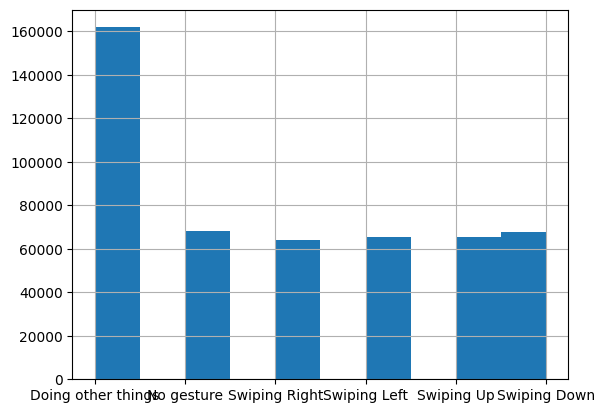

In [7]:
filtered_df['label'].hist()

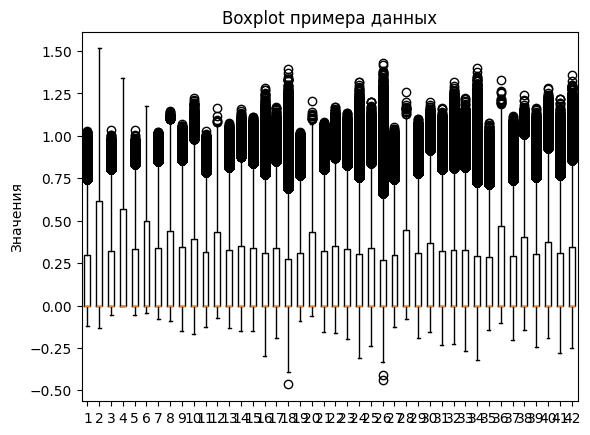

In [9]:
plt.boxplot(filtered_df.drop(columns=['label', 'path', 'label_id']))
plt.title("Boxplot примера данных")
plt.ylabel("Значения")
plt.show()

               label_id  landmark_0_x  landmark_0_y  landmark_1_x  \
label_id       1.000000      0.117134      0.060778      0.103834   
landmark_0_x   0.117134      1.000000      0.860385      0.995240   
landmark_0_y   0.060778      0.860385      1.000000      0.878733   
landmark_1_x   0.103834      0.995240      0.878733      1.000000   
landmark_1_y   0.058346      0.858169      0.997913      0.877657   
landmark_2_x   0.092134      0.985905      0.883871      0.996987   
landmark_2_y   0.061645      0.853757      0.990980      0.873671   
landmark_3_x   0.085331      0.977048      0.882717      0.991237   
landmark_3_y   0.068441      0.846653      0.979623      0.866663   
landmark_4_x   0.079622      0.968029      0.879421      0.984444   
landmark_4_y   0.075077      0.837898      0.965370      0.857573   
landmark_5_x   0.097600      0.987296      0.862169      0.993244   
landmark_5_y   0.075744      0.850663      0.984163      0.866074   
landmark_6_x   0.091542      0.975

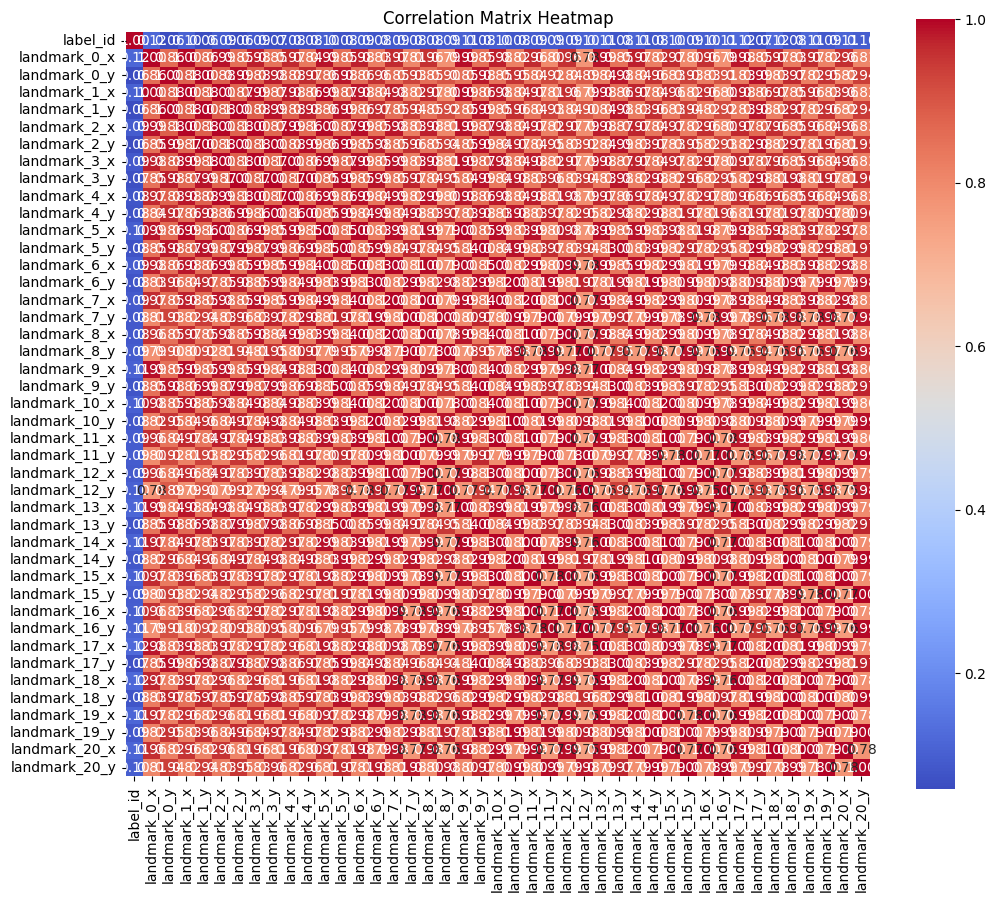

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = filtered_df.drop(columns=["label", "path"]).corr()

# 2. Выводим числовую таблицу корреляций
print(corr_matrix)

# 3. Визуализация тепловой карты корреляций
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [41]:
X, y = filtered_df.drop(columns=['label','label_id', 'path']), filtered_df['label_id']

In [42]:
print(X.shape, y.shape)

(492174, 42) (492174,)


In [43]:
minmax = RobustScaler()
X_scaled = minmax.fit_transform(X)

window_size_x = 37
window_size_y = 37
print(len(X), len(y))
n_samples = len(X_scaled) // window_size_x
n_samples_y = len(y) // window_size_y

y_seq = np.array(y[:n_samples_y * window_size_y]).reshape(n_samples_y, window_size_y)

y_seq = y_seq[:, 0] 

print(y_seq.shape)

X_scaled = X_scaled.reshape(n_samples, 37, 42)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_seq, train_size=0.8, random_state=13)
print(X_scaled.shape)

492174 492174
(13302,)
(13302, 37, 42)


Случайный сдвиг


In [44]:
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import random
from collections import Counter

minmax = RobustScaler()
X_scaled = minmax.fit_transform(X)

window_size = 37
stride_range = (5, 15) 

X_windows = []
y_windows = []

i = 0
while i + window_size <= len(X_scaled):
    window = X_scaled[i:i+window_size]
    label_window = y[i:i+window_size]

    label = Counter(label_window).most_common(1)[0][0]

    X_windows.append(window)
    y_windows.append(label)

    i += random.randint(*stride_range)

X_seq = np.array(X_windows)
y_seq = np.array(y_windows)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, train_size=0.8, random_state=13)

print(f"X shape: {X_seq.shape}, y shape: {y_seq.shape}")


X shape: (49220, 37, 42), y shape: (49220,)


In [45]:
import joblib

minmax.fit(X_train.reshape(-1, X_train.shape[-1]))
joblib.dump(minmax, 'minmax.save')

['minmax.save']

In [46]:
y_train = to_categorical(y_train, num_classes=6)
y_test = to_categorical(y_test, num_classes=6)

Раздуваем датасет для жеста Swipe Left

In [47]:
labels = np.argmax(y_train, axis=1)

swipe_left_indices = np.where(labels == 3)[0]

def is_nonzero_sequence(seq):
    return not np.any(np.all(seq == 0, axis=1))

valid_swipes = [i for i in swipe_left_indices if is_nonzero_sequence(X_train[i])]

X_dup = X_train[valid_swipes]
y_dup = y_train[valid_swipes]

def count_zero_rows(seq):
    return np.sum(np.all(seq == 0, axis=1))

invalid_swipes = [i for i in swipe_left_indices if count_zero_rows(X_train[i]) > 0]

to_remove = min(len(X_dup), len(invalid_swipes))

keep_indices = np.array([i for i in range(len(X_train)) if i not in invalid_swipes[:to_remove]])

X_train_final = np.concatenate([X_train[keep_indices], X_dup], axis=0)
y_train_final = np.concatenate([y_train[keep_indices], y_dup], axis=0)

assert X_train_final.shape[1:] == (37, 42), "Ошибка: не все последовательности длины 37"
assert y_train_final.shape[0] == X_train_final.shape[0], "Ошибка: размерности X и y не совпадают"

print(f"Новый размер X_train: {X_train_final.shape}")
print(f"Новый размер y_train: {y_train_final.shape}")


Новый размер X_train: (39376, 37, 42)
Новый размер y_train: (39376, 6)


In [176]:
y.value_counts()

label_id
1    64010
4    64010
2    64010
3    64010
0    64010
5    64010
Name: count, dtype: int64

In [48]:
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_test, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        cross_entropy = -y_test * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_sum(loss, axis=1)
    return focal_loss_fixed

In [49]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import Input
from keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Add, BatchNormalization  
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, classification_report
from tensorflow.keras.losses import CategoricalCrossentropy

# loss_fn = CategoricalCrossentropy()
# focal_loss(gamma=2., alpha=0.25)


input_layer = Input(shape=(37, 42))

x = Bidirectional(GRU(64, return_sequences=True, kernel_regularizer=l2(1e-4)))(input_layer)
x = LayerNormalization()(x)

residual = x

x = Bidirectional(GRU(64, return_sequences=True, kernel_regularizer=l2(1e-4)))(x)
x = LayerNormalization()(x)

x = Add()([x, residual])

attn_output = MultiHeadAttention(
    num_heads=4,
    key_dim=64,
    dropout=0.2
)(x, x)
x = BatchNormalization()(attn_output)
x = Dropout(0.5)(x)

x = GRU(64, kernel_regularizer=l2(1e-4))(x)
x = LeakyReLU(alpha=0.01)(x)

x = Dense(64, kernel_regularizer=l2(1e-4))(x)
x = LeakyReLU(alpha=0.01)(x)

output_layer = Dense(6, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)



model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=1e-4),
    loss=focal_loss(gamma=2., alpha=0.25),
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='roc_auc', curve='ROC', multi_label=True),
        AUC(name='pr_auc', curve='PR', multi_label=True)
    ]
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

callbacks = [early_stop, reduce_lr]

history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

results = model.evaluate(X_test, y_test, verbose=2)
print("Loss:", results[0])
print("Accuracy:", results[1])
print("Precision:", results[2])
print("Recall:", results[3])
print("ROC AUC:", results[4])
print("PR AUC:", results[5])


class_names = ['Doing other things', 'No gesture',
    'Swiping Down', 'Swiping Left', 'Swiping Right', 'Swiping Up']


y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

macro_precision = precision_score(y_true, y_pred, average='macro')
macro_recall = recall_score(y_true, y_pred, average='macro')

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")

print(classification_report(y_true, y_pred, target_names=class_names))

model.save("model_attention.keras")



Epoch 1/300
1231/1231 [==============================] - 32s 22ms/step - loss: 0.1803 - accuracy: 0.6405 - precision: 0.8603 - recall: 0.3932 - roc_auc: 0.8764 - pr_auc: 0.6748 - val_loss: 0.1476 - val_accuracy: 0.6856 - val_precision: 0.8714 - val_recall: 0.4858 - val_roc_auc: 0.9041 - val_pr_auc: 0.7351 - lr: 0.0010
Epoch 2/300
1231/1231 [==============================] - 27s 22ms/step - loss: 0.1446 - accuracy: 0.6861 - precision: 0.8752 - recall: 0.4719 - roc_auc: 0.8988 - pr_auc: 0.7217 - val_loss: 0.1371 - val_accuracy: 0.7015 - val_precision: 0.8743 - val_recall: 0.5046 - val_roc_auc: 0.9081 - val_pr_auc: 0.7461 - lr: 0.0010
Epoch 3/300
1231/1231 [==============================] - 28s 23ms/step - loss: 0.1348 - accuracy: 0.6954 - precision: 0.8827 - recall: 0.4898 - roc_auc: 0.9044 - pr_auc: 0.7356 - val_loss: 0.1259 - val_accuracy: 0.7118 - val_precision: 0.9009 - val_recall: 0.5068 - val_roc_auc: 0.9130 - val_pr_auc: 0.7565 - lr: 0.0010
Epoch 4/300
1231/1231 [=================

KeyboardInterrupt: 